In [24]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RectangleSelector
from IPython.display import display, clear_output
import ipywidgets as widgets
import os
from typing import Optional, List, Dict, Tuple, Union
from datetime import datetime
import yaml

In [84]:
class KeypointProcessor:
    """
    A flexible class for processing keypoint data from CSV files and extracting bounding boxes.
    """
    
    def __init__(self, img_width: int = 3208, img_height: int = 2200, 
                 keypoint_names: Optional[List[str]] = None,
                 default_seed: int = 42):
        """
        Initialize the KeypointProcessor with image dimensions and optional keypoint names.
        
        Args:
            img_width: Width of the original image
            img_height: Height of the original image
            keypoint_names: List of keypoint names (if None, default skeleton will be used)
            default_seed: Default seed for random operations
        """
        self.img_width = img_width
        self.img_height = img_height
        self.default_seed = default_seed
        
        # Set keypoint names (using defaults if none provided)
        self.keypoint_names = keypoint_names or self.get_default_skeleton_keypoints()
    
    def get_default_skeleton_keypoints(self) -> List[str]:
        """
        Returns the default skeleton keypoints.
        
        Returns:
            List of keypoint names
        """
        return [
            "Snout", "EarL", "EarR", "Neck", "SpineL", "TailBase", 
            "ShoulderL", "ElbowL", "WristL", "HandL", "ShoulderR", 
            "ElbowR", "WristR", "HandR", "KneeL", "AnkleL", "FootL", 
            "KneeR", "AnkleR", "FootR", "TailTip", "TailMid", 
            "Tail1Q", "Tail3Q"
        ]
    
    def generate_df_header(self, data_format: str = '2d_proj', 
                           include_keypoint_ids: bool = True,
                           custom_prefix: str = 'kpt') -> List[str]:
        """
        Generate column headers for DataFrame.
        
        Args:
            data_format: Format of the data ('2d_proj' for 2D projection)
            include_keypoint_ids: Whether to include keypoint IDs in the header
            custom_prefix: Custom prefix for keypoint IDs
        
        Returns:
            List of column headers
        """
        columns = ['frame_id']
        
        if data_format == '2d_proj':
            for idx, key in enumerate(self.keypoint_names):
                if include_keypoint_ids:
                    columns.append(f'{custom_prefix}_{idx}')
                columns.append(f'{key}_x')
                columns.append(f'{key}_y')
        elif data_format == '3d':
            for idx, key in enumerate(self.keypoint_names):
                if include_keypoint_ids:
                    columns.append(f'{custom_prefix}_{idx}')
                columns.append(f'{key}_x')
                columns.append(f'{key}_y')
                columns.append(f'{key}_z')
        
        return columns
    
    def sample_triangular(self, low: int, high: int, num_samples: int = 1, 
                          seed: Optional[int] = None) -> List[int]:
        """
        Sample from a triangular distribution with mode in the middle.
        
        Args:
            low: Lower bound
            high: Upper bound
            num_samples: Number of samples to generate
            seed: Random seed (for reproducibility)
        
        Returns:
            List of sorted unique integer samples
        """
        if seed is not None:
            np.random.seed(seed)
        
        mode = (low + high) / 2
        samples = np.random.triangular(low, mode, high, num_samples)
        return sorted(set(np.round(samples).astype(int).tolist()))
    
    def kpts_to_bbox(self, 
                        keypoints: Union[List[float], np.ndarray], 
                        format_type: str = "id_x_y",
                        norm_output: bool = True, 
                        flipud: bool = True,
                        filter_keypoints: Optional[List[int]] = None,
                        padding_factor: float = 2) -> Tuple[float, float, float, float]:
            """
            Extract bounding box from keypoints with added padding.
            
            Args:
                keypoints: List of keypoint coordinates
                format_type: Format of the keypoints ("id_x_y", "x_y", "x_y_conf")
                norm_output: Whether to normalize output to [0, 1]
                flipud: Whether to flip y-coordinates
                filter_keypoints: List of keypoint indices to consider (if None, all are used)
                padding_factor: Factor to increase the bounding box size (1.0 = no padding)
            
            Returns:
                Tuple (x, y, w, h) representing the bounding box
            """
            x_coord = []
            y_coord = []
            
            # Extract coordinates based on format
            if format_type == "id_x_y":
                # Format: [id1, x1, y1, id2, x2, y2, ...]
                x_coord = [keypoints[idx*3+1] for idx in range(len(keypoints)//3)]
                y_coord = [keypoints[idx*3+2] for idx in range(len(keypoints)//3)]
            elif format_type == "x_y":
                # Format: [x1, y1, x2, y2, ...]
                x_coord = [keypoints[idx*2] for idx in range(len(keypoints)//2)]
                y_coord = [keypoints[idx*2+1] for idx in range(len(keypoints)//2)]
            elif format_type == "x_y_conf":
                # Format: [x1, y1, conf1, x2, y2, conf2, ...]
                x_coord = [keypoints[idx*3] for idx in range(len(keypoints)//3)]
                y_coord = [keypoints[idx*3+1] for idx in range(len(keypoints)//3)]
            
            # Apply keypoint filtering if specified
            if filter_keypoints is not None:
                x_filtered = []
                y_filtered = []
                for idx in filter_keypoints:
                    if idx < len(x_coord):
                        x_filtered.append(x_coord[idx])
                        y_filtered.append(y_coord[idx])
                x_coord = x_filtered
                y_coord = y_filtered
            
            # Flip y-coordinates if required
            if flipud:
                y_coord = [self.img_height - y for y in y_coord]
            
            # Calculate bounding box
            if not x_coord or not y_coord:
                return 0, 0, 0, 0  # Return zeros if no valid coordinates
            
            x1 = float(np.min(x_coord))
            y1 = float(np.min(y_coord))
            x2 = float(np.max(x_coord))
            y2 = float(np.max(y_coord))
            
            # Calculate center point
            center_x = (x1 + x2) / 2.0
            center_y = (y1 + y2) / 2.0
            
            # Calculate original width and height
            original_width = x2 - x1
            original_height = y2 - y1
            
            # Apply padding factor to increase box size
            padded_width = original_width * padding_factor
            padded_height = original_height * padding_factor
            
            # Calculate new box coordinates from center
            new_x1 = center_x - padded_width / 2.0
            new_y1 = center_y - padded_height / 2.0
            new_x2 = center_x + padded_width / 2.0
            new_y2 = center_y + padded_height / 2.0
            
            # Calculate center and dimensions of padded box
            x = (new_x1 + new_x2) / 2.0
            y = (new_y1 + new_y2) / 2.0
            w = padded_width
            h = padded_height
            
            # Normalize if required
            if norm_output:
                x = x / self.img_width
                y = y / self.img_height
                w = w / self.img_width
                h = h / self.img_height
            
            return x, y, w, h
    
    def extract_keypoints_from_csv(self, 
                                 csv_file: str, 
                                 format_type: str = "id_x_y",
                                 column_name: str = "Rat4") -> pd.DataFrame:
        """
        Extract keypoints from a CSV file and generate a DataFrame.
        
        Args:
            csv_file: Path to the CSV file
            format_type: Format of the keypoints
            column_name: Name of the column containing the frame IDs
        
        Returns:
            DataFrame with extracted keypoints
        """
        # For this specific format, we need to read the file as text first
        with open(csv_file, 'r') as f:
            lines = f.readlines()
        
        keypoints_data = []
        
        # Parse header line if present (otherwise skip)
        start_idx = 0
        if ',' in lines[0] and not lines[0].strip().split(',')[0].isdigit():
            start_idx = 1
        
        # Process each line
        for line_idx in range(start_idx, len(lines)):
            line = lines[line_idx].strip()
            if not line:  # Skip empty lines
                continue
                
            # Split the line by commas
            parts = line.split(',')
            
            # First value is the frame_id
            frame_id = int(parts[0])
            
            # Rest of the parts are keypoints in format: point_id, x, y
            keypoints = []
            for i in range(1, len(parts), 3):
                # Make sure we have all three values (id, x, y)
                if i + 2 < len(parts) and parts[i] and parts[i+1] and parts[i+2]:
                    try:
                        point_id = float(parts[i])
                        x_coord = float(parts[i+1])
                        y_coord = float(parts[i+2])
                        keypoints.extend([point_id, x_coord, y_coord])
                    except (ValueError, IndexError):
                        # Skip invalid entries
                        pass
            
            # Generate bounding box
            x, y, w, h = self.kpts_to_bbox(keypoints, format_type="id_x_y")
            
            keypoints_data.append({
                'frame_id': frame_id,
                'keypoints_raw': keypoints,
                'bbox_x': x,
                'bbox_y': y,
                'bbox_width': w,
                'bbox_height': h
            })
        
        return pd.DataFrame(keypoints_data)
    
    def visualize_bbox(self, 
                      frame_id: int, 
                      df: pd.DataFrame,
                      output_path: Optional[str] = None) -> None:
        """
        Visualize bounding box for a specific frame.
        
        Args:
            frame_id: ID of the frame to visualize
            df: DataFrame containing bounding box information
            output_path: Path to save the visualization (if None, the plot is displayed)
        """
        # Get row for the specified frame_id
        row = df[df['frame_id'] == frame_id]
        
        if row.empty:
            print(f"Frame ID {frame_id} not found in DataFrame")
            return
        
        # Get bounding box coordinates
        x = row['bbox_x'].values[0] * self.img_width
        y = row['bbox_y'].values[0] * self.img_height
        w = row['bbox_width'].values[0] * self.img_width
        h = row['bbox_height'].values[0] * self.img_height
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create a placeholder for the image
        ax.set_xlim(0, self.img_width)
        ax.set_ylim(0, self.img_height)
        
        # Draw bounding box
        rect = plt.Rectangle((x - w/2, y - h/2), w, h, 
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Draw keypoints if available
        if 'keypoints_raw' in row.columns:
            keypoints = row['keypoints_raw'].values[0]
            
            if isinstance(keypoints, list):
                # Assuming id_x_y format
                for i in range(len(keypoints) // 3):
                    kpt_id = keypoints[i*3]
                    kpt_x = keypoints[i*3+1]
                    kpt_y = self.img_height - keypoints[i*3+2] if True else keypoints[i*3+2]
                    
                    ax.scatter(kpt_x, kpt_y, color='blue', s=30)
                    ax.text(kpt_x, kpt_y, str(int(kpt_id)), fontsize=8)
        
        # Set title and labels
        ax.set_title(f"Frame ID: {frame_id}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        
        # Save or display the plot
        if output_path:
            plt.savefig(output_path)
            plt.close()
        else:
            plt.show()
    
    def make_data_yaml(self, target_dir: str, class_names: List[str] = None) -> str:
        """
        Create a YAML file for training data configuration.
        
        Args:
            target_dir: Directory to save the YAML file
            class_names: List of class names (default: ["mouse", "ball"])
            
        Returns:
            Path to the created YAML file
        """
        if class_names is None:
            class_names = ["mouse", "ball"]
            
        # Create directory if it doesn't exist
        os.makedirs(target_dir, exist_ok=True)
            
        t_creation = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        # Define the YAML content as a Python dictionary
        data = {
            "names": class_names,
            "nc": len(class_names),
            "test": "../test/images",
            "train": "../train/images",
            "val": "../valid/images",
            "t_creation": t_creation
        }

        # Specify the file name
        yaml_filename = os.path.join(target_dir, "data.yaml")

        # Write to a YAML file
        with open(yaml_filename, "w") as file:
            yaml.dump(data, file, default_flow_style=False)

        print(f"YAML file '{yaml_filename}' created successfully.")
        return yaml_filename

    def get_frame(self, frame_idx, video_path=None):
        """
        Get a specific frame from a video.
        
        Args:
            frame_idx: Index of the frame to retrieve
            video_path: Path to the video file (if None, uses self.video_path if available)
        
        Returns:
            The requested frame as a numpy array, or None if frame could not be read
        """
        # Determine which video path to use
        if video_path is None:
            if hasattr(self, 'video_path'):
                video_path = self.video_path
            else:
                print("No video path provided and no default video path available.")
                return None
        
        # Open the video
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Could not open video file: {video_path}")
            return None
        
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        
        # Read the frame
        ret, frame = cap.read()
        
        # Release the video capture
        cap.release()
        
        if not ret:
            print(f"Could not read frame {frame_idx}")
            return None
        
        return frame
    
    def generate_yolo_annotations(self, 
                                df: pd.DataFrame, 
                                class_id: int = 0,
                                output_dir: str = 'annotations') -> None:
        """
        Generate YOLO format annotations from DataFrame.
        
        Args:
            df: DataFrame containing bounding box information
            class_id: Class ID for the annotations
            output_dir: Directory to save the annotations
        """
        # Create directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate annotation files
        for _, row in df.iterrows():
            frame_id = row['frame_id']
            x = row['bbox_x']
            y = row['bbox_y']
            w = row['bbox_width']
            h = row['bbox_height']
            
            # Write to file
            filename = os.path.join(output_dir, f"{frame_id}.txt")
            with open(filename, 'w') as f:
                f.write(f"{class_id} {x} {y} {w} {h}\n")
        
        print(f"Generated {len(df)} annotation files in '{output_dir}'")

    def kpts_to_bbox(self, 
            keypoints: Union[List[float], np.ndarray], 
            format_type: str = "id_x_y",
            norm_output: bool = True, 
            flipud: bool = True,
            filter_keypoints: Optional[List[int]] = None,
            padding_factor: float = 1.1,
            oriented: bool = False) -> Union[Tuple[float, float, float, float], Tuple[float, float, float, float, float]]:
        """
        Extract bounding box from keypoints with added padding, supporting both regular and oriented bounding boxes.
        
        Args:
            keypoints: List of keypoint coordinates
            format_type: Format of the keypoints ("id_x_y", "x_y", "x_y_conf")
            norm_output: Whether to normalize output to [0, 1]
            flipud: Whether to flip y-coordinates
            filter_keypoints: List of keypoint indices to consider (if None, all are used)
            padding_factor: Factor to increase the bounding box size (1.0 = no padding)
            oriented: Whether to compute an oriented bounding box (OBB) instead of axis-aligned box
        
        Returns:
            If oriented=False: Tuple (x, y, w, h) representing axis-aligned bounding box
            If oriented=True: Tuple (x, y, w, h, angle) representing oriented bounding box
        """
        x_coord = []
        y_coord = []
        
        # Extract coordinates based on format
        if format_type == "id_x_y":
            # Format: [id1, x1, y1, id2, x2, y2, ...]
            x_coord = [keypoints[idx*3+1] for idx in range(len(keypoints)//3)]
            y_coord = [keypoints[idx*3+2] for idx in range(len(keypoints)//3)]
        elif format_type == "x_y":
            # Format: [x1, y1, x2, y2, ...]
            x_coord = [keypoints[idx*2] for idx in range(len(keypoints)//2)]
            y_coord = [keypoints[idx*2+1] for idx in range(len(keypoints)//2)]
        elif format_type == "x_y_conf":
            # Format: [x1, y1, conf1, x2, y2, conf2, ...]
            x_coord = [keypoints[idx*3] for idx in range(len(keypoints)//3)]
            y_coord = [keypoints[idx*3+1] for idx in range(len(keypoints)//3)]
        
        # Apply keypoint filtering if specified
        if filter_keypoints is not None:
            x_filtered = []
            y_filtered = []
            for idx in filter_keypoints:
                if idx < len(x_coord):
                    x_filtered.append(x_coord[idx])
                    y_filtered.append(y_coord[idx])
            x_coord = x_filtered
            y_coord = y_filtered
        
        # Flip y-coordinates if required
        if flipud:
            y_coord = [self.img_height - y for y in y_coord]
        
        # Calculate bounding box
        if not x_coord or not y_coord:
            return (0, 0, 0, 0) if not oriented else (0, 0, 0, 0, 0)
        
        # Create a combined list of points
        points = np.array(list(zip(x_coord, y_coord)), dtype=np.float32)
        
        if oriented:
            # Calculate oriented bounding box
            # OpenCV's minAreaRect returns ((center_x, center_y), (width, height), angle)
            rect = cv2.minAreaRect(points)
            center = rect[0]
            size = rect[1]
            angle = rect[2]  # Angle in degrees
            
            # Apply padding factor to increase box size (maintain aspect ratio)
            padded_width = size[0] * padding_factor
            padded_height = size[1] * padding_factor
            
            # Create the padded rectangle
            center_x, center_y = center
            width, height = padded_width, padded_height
            
            # Normalize if required
            if norm_output:
                center_x = center_x / self.img_width
                center_y = center_y / self.img_height
                width = width / self.img_width
                height = height / self.img_height
            
            # Return center_x, center_y, width, height, angle
            return (center_x, center_y, width, height, angle)
        else:
            # Standard axis-aligned bounding box
            x1 = float(np.min(x_coord))
            y1 = float(np.min(y_coord))
            x2 = float(np.max(x_coord))
            y2 = float(np.max(y_coord))
            
            # Calculate center point
            center_x = (x1 + x2) / 2.0
            center_y = (y1 + y2) / 2.0
            
            # Calculate original width and height
            original_width = x2 - x1
            original_height = y2 - y1
            
            # Apply padding factor to increase box size
            padded_width = original_width * padding_factor
            padded_height = original_height * padding_factor
            
            # Calculate new box coordinates from center
            new_x1 = center_x - padded_width / 2.0
            new_y1 = center_y - padded_height / 2.0
            new_x2 = center_x + padded_width / 2.0
            new_y2 = center_y + padded_height / 2.0
            
            # Calculate center and dimensions of padded box
            x = (new_x1 + new_x2) / 2.0
            y = (new_y1 + new_y2) / 2.0
            w = padded_width
            h = padded_height
            
            # Normalize if required
            if norm_output:
                x = x / self.img_width
                y = y / self.img_height
                w = w / self.img_width
                h = h / self.img_height
            
            return (x, y, w, h)

    def draw_bounding_box(self, 
                        frame: np.ndarray, 
                        bbox: Union[Tuple[float, float, float, float], Tuple[float, float, float, float, float]],
                        is_oriented: bool = False,
                        is_normalized: bool = True,
                        color: Tuple[int, int, int] = (0, 255, 0),
                        thickness: int = 2,
                        label: Optional[str] = None) -> np.ndarray:
        """
        Draw a bounding box on a frame.
        
        Args:
            frame: The image frame to draw on
            bbox: Bounding box coordinates (x, y, w, h) or (x, y, w, h, angle)
            is_oriented: Whether the bounding box is oriented (has angle)
            is_normalized: Whether the coordinates are normalized [0,1]
            color: RGB color tuple for the box
            thickness: Line thickness
            label: Optional label to display
            
        Returns:
            Frame with bounding box drawn
        """
        height, width = frame.shape[:2]
        
        if is_oriented:
            # Unpack oriented bounding box
            if len(bbox) != 5:
                raise ValueError("Oriented bounding box must have 5 values (x, y, w, h, angle)")
            
            x, y, w, h, angle = bbox
            
            # Denormalize if needed
            if is_normalized:
                x = x * width
                y = y * height
                w = w * width
                h = h * height
            
            # Get the rotated rectangle points
            # cv2.boxPoints expects ((center_x, center_y), (width, height), angle)
            rect = ((x, y), (w, h), angle)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            # Draw the rotated rectangle
            cv2.drawContours(frame, [box], 0, color, thickness)
            
            # Draw label if provided
            if label:
                # Find the top-left point to place text
                text_pt = (min(box[:, 0]), min(box[:, 1]) - 10)
                cv2.putText(frame, label, text_pt, cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        else:
            # Unpack axis-aligned bounding box
            if len(bbox) != 4:
                raise ValueError("Axis-aligned bounding box must have 4 values (x, y, w, h)")
            
            x, y, w, h = bbox
            
            # Denormalize if needed
            if is_normalized:
                x = x * width
                y = y * height
                w = w * width
                h = h * height
            
            # Calculate corners
            x1 = int(x - w/2)
            y1 = int(y - h/2)
            x2 = int(x + w/2)
            y2 = int(y + h/2)
            
            # Draw the rectangle
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
            
            # Draw label if provided
            if label:
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        return frame
    
    def generate_yolo_annotations(self, 
                               df: pd.DataFrame,
                               class_id: int = 0,
                               output_dir: str = 'annotations',
                               oriented: bool = False) -> None:
        """
        Generate YOLO format annotations from DataFrame.
        
        Args:
            df: DataFrame containing bounding box information
            class_id: Class ID for the annotations
            output_dir: Directory to save the annotations
            oriented: Whether to generate oriented bounding box (OBB) annotations
                      (only for YOLOv8-OBB format)
        """
        # Create directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate annotation files
        for _, row in df.iterrows():
            frame_id = row['frame_id']
            
            if oriented:
                # Check if we have the necessary columns for oriented boxes
                if 'bbox_angle' not in row:
                    # Calculate oriented bounding box on the fly if needed
                    if 'keypoints_raw' in row:
                        keypoints = row['keypoints_raw']
                        x, y, w, h, angle = self.kpts_to_bbox(
                            keypoints, 
                            oriented=True,
                            padding_factor=1.2
                        )
                    else:
                        # Fallback if we don't have keypoints
                        x, y, w, h = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']
                        angle = 0  # Default to 0 if we can't calculate
                else:
                    # Use pre-calculated values
                    x, y, w, h = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']
                    angle = row['bbox_angle']
                
                # Write to file in YOLOv8-OBB format:
                # <class> <cx> <cy> <width> <height> <rotation>
                filename = os.path.join(output_dir, f"{frame_id}.txt")
                with open(filename, 'w') as f:
                    f.write(f"{class_id} {x} {y} {w} {h} {angle/180.0*np.pi}\n")
            else:
                # Standard YOLO format (x, y, w, h)
                x = row['bbox_x']
                y = row['bbox_y']
                w = row['bbox_width']
                h = row['bbox_height']
                
                # Write to file in standard YOLO format:
                # <class> <x_center> <y_center> <width> <height>
                filename = os.path.join(output_dir, f"{frame_id}.txt")
                with open(filename, 'w') as f:
                    f.write(f"{class_id} {x} {y} {w} {h}\n")
        
        if oriented:
            # Additionally create a dataset.yaml file for YOLOv8-OBB
            yaml_path = os.path.join(output_dir, "dataset.yaml")
            with open(yaml_path, 'w') as f:
                f.write(f"# YOLOv8-OBB dataset configuration\n")
                f.write(f"path: {os.path.abspath(output_dir)}\n")
                f.write(f"train: images/train\n")
                f.write(f"val: images/val\n")
                f.write(f"test: images/test\n\n")
                f.write(f"names:\n")
                f.write(f"  0: fish\n")
        
        print(f"Generated annotations in '{output_dir}' for {'oriented' if oriented else 'standard'} bounding boxes")



    def visualize_bbox_comparison(self, 
                             frame_id: int, 
                             df: pd.DataFrame,
                             output_path: Optional[str] = None,
                             show_keypoints: bool = True,
                             video_path: Optional[str] = None) -> None:
        """
        Visualize both regular and oriented bounding boxes for comparison.
        
        Args:
            frame_id: ID of the frame to visualize
            df: DataFrame containing bounding box information
            output_path: Path to save the visualization (if None, the plot is displayed)
            show_keypoints: Whether to show keypoints
            video_path: Path to the video file (if None, uses self.video_path if available)
        """
        # Get row for the specified frame_id
        row = df[df['frame_id'] == frame_id]
        
        if row.empty:
            print(f"Frame ID {frame_id} not found in DataFrame")
            return
        
        # Get the frame from video if available
        frame = None
        if hasattr(self, 'get_frame') and callable(getattr(self, 'get_frame')):
            frame = self.get_frame(frame_id, video_path)
        
        # If frame wasn't retrieved from video, create a blank canvas
        if frame is None:
            frame = np.ones((self.img_height, self.img_width, 3), dtype=np.uint8) * 255
        
        # Make a copy to avoid modifying the original
        vis_frame = frame.copy()
        
        # Get standard bbox
        x, y, w, h = (
            row['bbox_x'].values[0],
            row['bbox_y'].values[0],
            row['bbox_width'].values[0],
            row['bbox_height'].values[0]
        )
        
        # Draw standard bounding box in green
        self.draw_bounding_box(
            vis_frame, 
            (x, y, w, h), 
            is_oriented=False, 
            is_normalized=True,
            color=(0, 255, 0),  # Green
            label="Standard"
        )
        
        # Calculate oriented bounding box if not already in DataFrame
        if 'bbox_obb_x' not in row.columns or 'bbox_angle' not in row.columns:
            if 'keypoints_raw' in row.columns:
                keypoints = row['keypoints_raw'].values[0]
                x_obb, y_obb, w_obb, h_obb, angle = self.kpts_to_bbox(
                    keypoints, 
                    oriented=True,
                    padding_factor=1.2
                )
            else:
                # If no keypoints available, use the standard bbox with 0 angle
                x_obb, y_obb, w_obb, h_obb, angle = x, y, w, h, 0
        else:
            # Use pre-calculated values
            x_obb = row['bbox_obb_x'].values[0]
            y_obb = row['bbox_obb_y'].values[0]
            w_obb = row['bbox_obb_width'].values[0]
            h_obb = row['bbox_obb_height'].values[0]
            angle = row['bbox_angle'].values[0]
        
        # Draw oriented bounding box in blue
        self.draw_bounding_box(
            vis_frame, 
            (x_obb, y_obb, w_obb, h_obb, angle), 
            is_oriented=True, 
            is_normalized=True,
            color=(255, 0, 0),  # Blue
            label="Oriented"
        )
        
        # Draw keypoints if requested
        if show_keypoints and 'keypoints_raw' in row.columns:
            keypoints = row['keypoints_raw'].values[0]
            
            # Assuming id_x_y format
            for i in range(len(keypoints) // 3):
                kpt_id = int(keypoints[i*3])
                kpt_x = int(keypoints[i*3+1])  # Use raw values without scaling
                kpt_y = int(self.img_height - keypoints[i*3+2]) if True else int(keypoints[i*3+2])
                
                # Draw keypoint
                cv2.circle(vis_frame, (kpt_x, kpt_y), 5, (0, 0, 255), -1)
                
                # Draw keypoint ID
                cv2.putText(
                    vis_frame,
                    str(kpt_id),
                    (kpt_x + 5, kpt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0, 0, 255),
                    1
                )
        
        # Convert BGR to RGB for matplotlib if needed
        if vis_frame.shape[2] == 3 and vis_frame.dtype == np.uint8:
            vis_frame_rgb = cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB)
        else:
            vis_frame_rgb = vis_frame
        
        # Display or save
        plt.figure(figsize=(12, 8))
        plt.imshow(vis_frame_rgb)
        plt.title(f"Frame {frame_id} - Bounding Box Comparison")
        plt.axis('off')
        
        if output_path:
            plt.savefig(output_path)
            plt.close()
            print(f"Saved visualization to {output_path}")
        else:
            plt.show()

    def extract_keypoints_with_oriented_bbox(self, 
                                     csv_file: str, 
                                     format_type: str = "id_x_y",
                                     column_name: str = "Rat4",
                                     padding_factor: float = 1.2) -> pd.DataFrame:
        """
        Extract keypoints from a CSV file and generate a DataFrame with both regular and oriented bounding boxes.
        
        Args:
            csv_file: Path to the CSV file
            format_type: Format of the keypoints
            column_name: Name of the column containing the frame IDs
            padding_factor: Factor to increase the bounding box size
        
        Returns:
            DataFrame with extracted keypoints and both types of bounding boxes
        """
        # For this specific format, we need to read the file as text first
        with open(csv_file, 'r') as f:
            lines = f.readlines()
        
        keypoints_data = []
        
        # Parse header line if present (otherwise skip)
        start_idx = 0
        if ',' in lines[0] and not lines[0].strip().split(',')[0].isdigit():
            start_idx = 1
        
        # Process each line
        for line_idx in range(start_idx, len(lines)):
            line = lines[line_idx].strip()
            if not line:  # Skip empty lines
                continue
                
            # Split the line by commas
            parts = line.split(',')
            
            # First value is the frame_id
            frame_id = int(parts[0])
            
            # Rest of the parts are keypoints in format: point_id, x, y
            keypoints = []
            for i in range(1, len(parts), 3):
                # Make sure we have all three values (id, x, y)
                if i + 2 < len(parts) and parts[i] and parts[i+1] and parts[i+2]:
                    try:
                        point_id = float(parts[i])
                        x_coord = float(parts[i+1])
                        y_coord = float(parts[i+2])
                        keypoints.extend([point_id, x_coord, y_coord])
                    except (ValueError, IndexError):
                        # Skip invalid entries
                        pass
            
            # Generate regular bounding box
            x, y, w, h = self.kpts_to_bbox(
                keypoints, 
                format_type="id_x_y", 
                padding_factor=padding_factor,
                oriented=False
            )
            
            # Generate oriented bounding box
            x_obb, y_obb, w_obb, h_obb, angle = self.kpts_to_bbox(
                keypoints, 
                format_type="id_x_y", 
                padding_factor=padding_factor,
                oriented=True
            )
            
            keypoints_data.append({
                'frame_id': frame_id,
                'keypoints_raw': keypoints,
                # Regular bounding box
                'bbox_x': x,
                'bbox_y': y,
                'bbox_width': w,
                'bbox_height': h,
                # Oriented bounding box
                'bbox_obb_x': x_obb,
                'bbox_obb_y': y_obb,
                'bbox_obb_width': w_obb,
                'bbox_obb_height': h_obb,
                'bbox_angle': angle
            })
        
        return pd.DataFrame(keypoints_data)

/tmp/ipykernel_25842/2989341778.py:597: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


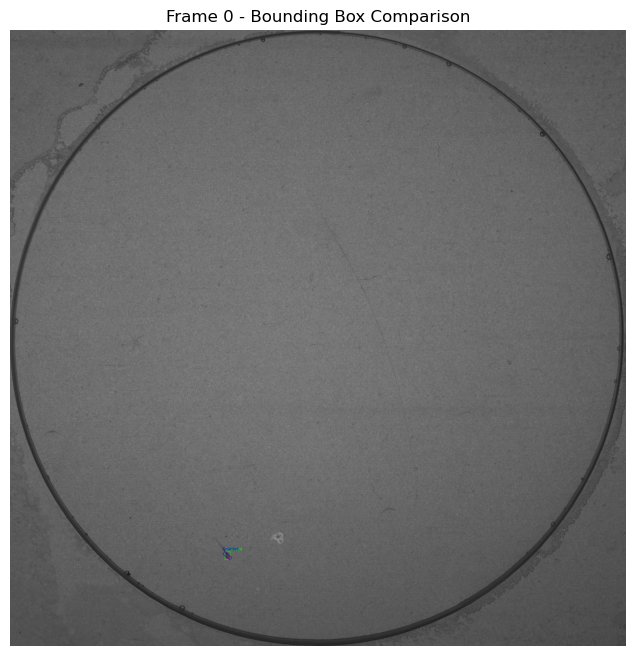

In [75]:
# Initialize processor with your image dimensions
processor = KeypointProcessor(img_width=4512, img_height=4512)

# Process your CSV file to get both types of bounding boxes
df_keypoints = processor.extract_keypoints_with_oriented_bbox(
    "Cam2010094_2025_01_30_21_19_30.csv",
    padding_factor=1.3  # Use your preferred padding factor
)

# Visualize a frame with both bounding box types
processor.visualize_bbox_comparison(
    frame_id=0,  # Choose any frame ID in your data
    df=df_keypoints,
    show_keypoints=True,
    # Optionally specify video path if you want to show the actual frame
    video_path="Cam2010094.mp4"  
)

Extracted 290 frames
Bounding box statistics:
           bbox_x      bbox_y  bbox_width  bbox_height
count  290.000000  290.000000  290.000000   290.000000
mean     0.365597    0.835389    0.009474     0.011002
std      0.074220    0.061943    0.003130     0.003370
min      0.124637    0.708405    0.004471     0.004694
25%      0.355413    0.811435    0.007050     0.007236
50%      0.382606    0.854659    0.008941     0.012535
75%      0.411885    0.870084    0.012164     0.013603
max      0.464013    0.925150    0.015596     0.016171


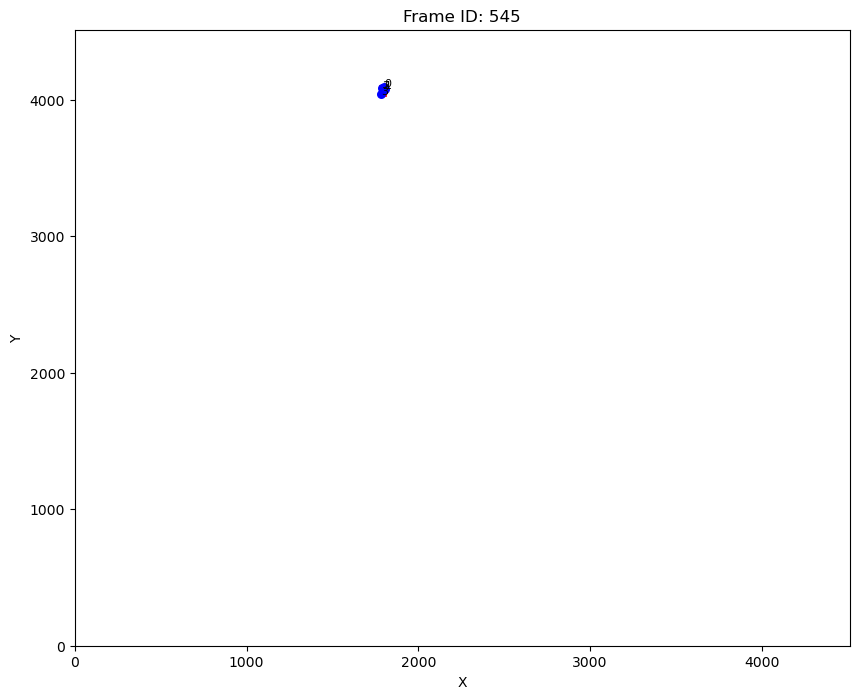

Generated annotations in 'annotations' for standard bounding boxes
YAML file 'annotations/data.yaml' created successfully.


'annotations/data.yaml'

In [57]:
processor = KeypointProcessor(img_width=4512, img_height=4512)

# Extract keypoints from CSV file
csv_file = "Cam2010094_2025_01_30_21_19_30.csv"
df_keypoints = processor.extract_keypoints_from_csv(csv_file)

# Show some statistics
print(f"Extracted {len(df_keypoints)} frames")
print(f"Bounding box statistics:")
print(df_keypoints[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].describe())

# Visualize a random frame
random_frame = df_keypoints['frame_id'].sample(1).values[0]
processor.visualize_bbox(random_frame, df_keypoints)

# Generate YOLO annotations
processor.generate_yolo_annotations(df_keypoints, class_id=0, output_dir='annotations')

# Create data.yaml file
processor.make_data_yaml('annotations', class_names=["rat", "object"])

In [82]:
def visualize_video_frames_with_dual_boxes(
    video_path: str,
    keypoints_csv: str,
    output_dir: Optional[str] = "output_frames",
    frame_indices: Optional[List[int]] = None,
    img_width: int = 4512,
    img_height: int = 4512,
    show_keypoints: bool = True,
    save_frames: bool = True,
    display_frames: bool = True,
    padding_factor: float = 2.0,
    show_standard_box: bool = True,
    show_oriented_box: bool = True,
    zoom_to_box: bool = True,
    zoom_padding: int = 100  # Pixels of padding around the zoomed region
) -> None:
    """
    Visualize video frames with both standard and oriented bounding boxes from keypoint data.
    
    Args:
        video_path: Path to the video file
        keypoints_csv: Path to the CSV file with keypoints
        output_dir: Directory to save the output frames
        frame_indices: List of frame indices to visualize (if None, use the first 5 frames)
        img_width: Width of the original image
        img_height: Height of the original image
        show_keypoints: Whether to show keypoints in addition to bounding boxes
        save_frames: Whether to save frames to disk
        display_frames: Whether to display frames in the notebook
        padding_factor: Factor to increase the bounding box size
        show_standard_box: Whether to show the standard axis-aligned box
        show_oriented_box: Whether to show the oriented box
        zoom_to_box: Whether to zoom in on the bounding box area
        zoom_padding: Pixels of padding around the zoomed region
    """
    # Create output directory if needed
    if save_frames and output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Initialize KeypointProcessor
    processor = KeypointProcessor(img_width=img_width, img_height=img_height)
    
    # Load keypoints data with both types of bounding boxes
    df_keypoints = processor.extract_keypoints_with_oriented_bbox(
        keypoints_csv, 
        padding_factor=padding_factor
    )
    
    # Create a frame mapping for quick lookup
    frame_map = {row['frame_id']: row for _, row in df_keypoints.iterrows()}
    
    # Open the video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return
    
    # Get video properties
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties:")
    print(f"  - Dimensions: {video_width}x{video_height}")
    print(f"  - FPS: {fps}")
    print(f"  - Total frames: {total_frames}")
    print(f"  - Duration: {total_frames/fps:.2f} seconds")
    
    # Determine which frames to process
    if frame_indices is None:
        # Use frame IDs from the keypoints data (first 5 or fewer)
        frame_indices = sorted(df_keypoints['frame_id'].unique()[:5])
    
    # Process frames
    for frame_idx in frame_indices:
        # Try to find this frame in our keypoints data
        if frame_idx not in frame_map:
            print(f"Warning: Frame {frame_idx} not found in keypoints data. Skipping.")
            continue
        
        # Set video position to this frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        
        # Read the frame
        ret, frame = cap.read()
        
        if not ret:
            print(f"Warning: Could not read frame {frame_idx} from video.")
            continue
        
        # Get keypoints and bounding box data for this frame
        keypoint_data = frame_map[frame_idx]
        
        # Make a copy of the frame to draw on
        annotated_frame = frame.copy()
        
        # Track the bounding region for zooming
        min_x, min_y, max_x, max_y = video_width, video_height, 0, 0
        
        # Draw standard bounding box if requested
        if show_standard_box:
            # Get normalized standard bounding box coordinates
            x, y, w, h = (
                keypoint_data['bbox_x'],
                keypoint_data['bbox_y'],
                keypoint_data['bbox_width'],
                keypoint_data['bbox_height']
            )
            
            # Convert normalized coordinates to pixel coordinates for this frame
            x_pixel = int(x * video_width)
            y_pixel = int(y * video_height)
            w_pixel = int(w * video_width)
            h_pixel = int(h * video_height)
            
            # Calculate bounding box corners
            x1 = max(0, int(x_pixel - w_pixel / 2))
            y1 = max(0, int(y_pixel - h_pixel / 2))
            x2 = min(video_width - 1, int(x_pixel + w_pixel / 2))
            y2 = min(video_height - 1, int(y_pixel + h_pixel / 2))
            
            # Update the zoom region
            min_x = min(min_x, x1)
            min_y = min(min_y, y1)
            max_x = max(max_x, x2)
            max_y = max(max_y, y2)
            
            # Draw standard bounding box on the frame (in green)
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add label for standard box
            cv2.putText(
                annotated_frame,
                "Standard",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 255, 0),
                2
            )
        
        # Draw oriented bounding box if requested
        if show_oriented_box:
            # Get normalized oriented bounding box coordinates
            x_obb, y_obb, w_obb, h_obb, angle = (
                keypoint_data['bbox_obb_x'],
                keypoint_data['bbox_obb_y'],
                keypoint_data['bbox_obb_width'],
                keypoint_data['bbox_obb_height'],
                keypoint_data['bbox_angle']
            )
            
            # Convert normalized coordinates to pixel coordinates
            x_obb_pixel = int(x_obb * video_width)
            y_obb_pixel = int(y_obb * video_height)
            w_obb_pixel = int(w_obb * video_width)
            h_obb_pixel = int(h_obb * video_height)
            
            # Draw oriented bounding box (in blue)
            # Create rotated rectangle
            rect = ((x_obb_pixel, y_obb_pixel), (w_obb_pixel, h_obb_pixel), angle)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            # Update the zoom region based on oriented box corners
            for point in box:
                min_x = min(min_x, point[0])
                min_y = min(min_y, point[1])
                max_x = max(max_x, point[0])
                max_y = max(max_y, point[1])
            
            # Draw the oriented rectangle
            cv2.drawContours(annotated_frame, [box], 0, (255, 0, 0), 2)
            
            # Add label for oriented box
            cv2.putText(
                annotated_frame,
                "Oriented",
                (int(box[0][0]), int(box[0][1]) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 0, 0),
                2
            )
        
        # Draw keypoints if requested
        if show_keypoints and 'keypoints_raw' in keypoint_data:
            keypoints = keypoint_data['keypoints_raw']
            
            # Assuming id_x_y format
            for i in range(len(keypoints) // 3):
                kpt_id = int(keypoints[i*3])
                kpt_x = int(keypoints[i*3+1] * video_width / img_width)
                kpt_y = int((img_height - keypoints[i*3+2]) * video_height / img_height)
                
                # Update the zoom region based on keypoints
                min_x = min(min_x, kpt_x - 5)
                min_y = min(min_y, kpt_y - 5)
                max_x = max(max_x, kpt_x + 5)
                max_y = max(max_y, kpt_y + 5)
                
                # Draw keypoint
                cv2.circle(annotated_frame, (kpt_x, kpt_y), 5, (0, 0, 255), -1)
                
                # Draw keypoint ID
                cv2.putText(
                    annotated_frame,
                    str(kpt_id),
                    (kpt_x + 5, kpt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0, 0, 255),
                    1
                )
        
        # Add frame number (larger and more visible)
        # First, create a background rectangle for better visibility
        frame_text = f"FRAME {frame_idx}"
        text_size = cv2.getTextSize(frame_text, cv2.FONT_HERSHEY_SIMPLEX, 2.0, 3)[0]
        cv2.rectangle(
            annotated_frame, 
            (10, 10), 
            (10 + text_size[0] + 20, 10 + text_size[1] + 20),
            (0, 0, 0),
            -1  # Fill the rectangle
        )
        
        # Then add the text
        cv2.putText(
            annotated_frame,
            frame_text,
            (20, 50),  # Position adjusted for better visibility
            cv2.FONT_HERSHEY_SIMPLEX,
            2.0,  # Larger font size
            (255, 255, 255),  # White text
            3    # Thicker line
        )
        
        # Determine if we need to zoom to the bounding box area
        if zoom_to_box and (min_x < max_x and min_y < max_y):
            # Add padding around the region
            min_x = max(0, min_x - zoom_padding)
            min_y = max(0, min_y - zoom_padding)
            max_x = min(video_width - 1, max_x + zoom_padding)
            max_y = min(video_height - 1, max_y + zoom_padding)
            
            # Crop to the region of interest
            zoomed_frame = annotated_frame[min_y:max_y, min_x:max_x]
            
            # Create a composite image showing both full and zoomed views
            if zoomed_frame.size > 0:  # Ensure the zoomed frame is not empty
                # Define fixed sizes for display
                fixed_height = 600  # Fixed height for both views
                
                # Calculate aspect ratios
                full_aspect = video_width / video_height
                zoom_aspect = (max_x - min_x) / (max_y - min_y)
                
                # Calculate widths based on fixed height
                full_width = int(fixed_height * full_aspect)
                zoom_width = int(fixed_height * zoom_aspect)
                
                # Resize both views to their target sizes
                resized_full = cv2.resize(annotated_frame, (full_width, fixed_height))
                resized_zoom = cv2.resize(zoomed_frame, (zoom_width, fixed_height))
                
                # Create a composite image wide enough for both views
                total_width = max(full_width, zoom_width)
                total_height = fixed_height * 2 + 60  # Space for two views plus labels
                
                composite = np.ones((total_height, total_width, 3), dtype=np.uint8) * 255
                
                # Place the full view on top (centered)
                full_start_x = (total_width - full_width) // 2
                composite[0:fixed_height, full_start_x:full_start_x + full_width] = resized_full
                
                # Add separator and label
                cv2.line(composite, (0, fixed_height + 20), (total_width, fixed_height + 20), (0, 0, 0), 2)
                
                # Add "Zoomed View" text
                zoom_text = "ZOOMED VIEW"
                zoom_text_size = cv2.getTextSize(zoom_text, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)[0]
                zoom_text_x = (total_width - zoom_text_size[0]) // 2  # Center text
                
                cv2.putText(
                    composite,
                    zoom_text,
                    (zoom_text_x, fixed_height + 45),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.0,
                    (0, 0, 0),
                    2
                )
                
                # Place the zoomed view below (centered)
                zoom_start_x = (total_width - zoom_width) // 2
                zoom_start_y = fixed_height + 60
                zoom_end_y = zoom_start_y + fixed_height
                zoom_end_x = zoom_start_x + zoom_width
                
                # Ensure we're not going out of bounds
                if zoom_end_y <= composite.shape[0] and zoom_end_x <= composite.shape[1]:
                    composite[zoom_start_y:zoom_end_y, zoom_start_x:zoom_end_x] = resized_zoom
                
                # Use the composite for display and saving
                display_image = composite
                display_image_rgb = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)
            else:
                # Fallback to original frame if zoom region is invalid
                display_image = annotated_frame
                display_image_rgb = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)
        else:
            # Use the annotated frame without zooming
            display_image = annotated_frame
            display_image_rgb = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)
        
        # Save frame if requested
        if save_frames and output_dir:
            output_path = os.path.join(output_dir, f"frame_{frame_idx:04d}_dual_boxes.jpg")
            cv2.imwrite(output_path, display_image)
            print(f"Saved frame to {output_path}")
        
        # Display frame if requested
        if display_frames:
            plt.figure(figsize=(16, 12))  # Larger figure size for better visibility
            plt.imshow(display_image_rgb)
            plt.title(f"Frame {frame_idx} - Standard (Green) and Oriented (Blue) Boxes")
            plt.axis('off')
            plt.show()
    
    # Release video capture
    cap.release()
    
    print("Frame visualization complete.")

Video properties:
  - Dimensions: 4512x4512
  - FPS: 70.03891050583658
  - Total frames: 13125
  - Duration: 187.40 seconds
Saved frame to output_frames/frame_0000_dual_boxes.jpg


/tmp/ipykernel_25842/1588427997.py:165: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


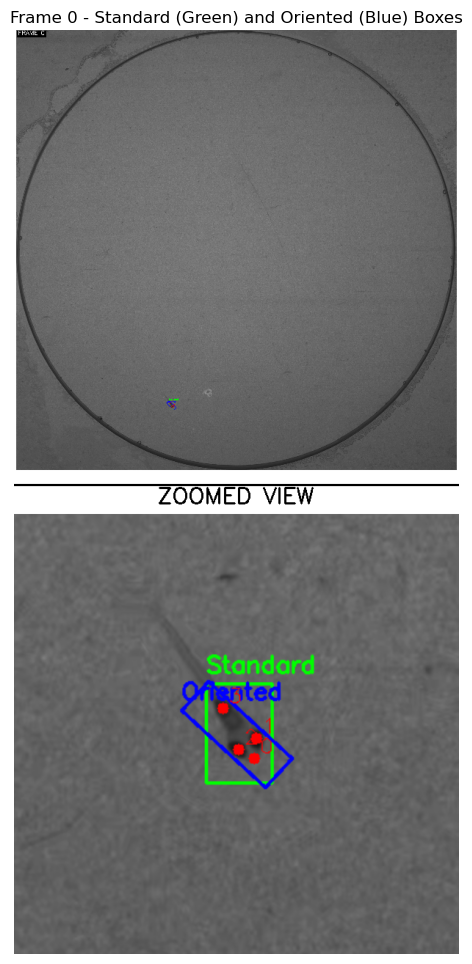

Frame visualization complete.


In [83]:
# Example usage of the fixed visualizer
video_path = "Cam2010094.mp4"  # Path to your video file
keypoints_csv = "Cam2010094_2025_01_30_21_19_30.csv"  # Path to your keypoints CSV

# Visualize a single frame
visualize_video_frames_with_dual_boxes(
    video_path=video_path,
    keypoints_csv=keypoints_csv,
    frame_indices=[0],  # Just visualize frame 0
    img_width=4512,
    img_height=4512,
    zoom_to_box=True,
    zoom_padding=150  # Add 150 pixels of padding around the zoomed region
)

# # To visualize just a single frame with extra zoom padding:
# visualize_video_frames_with_dual_boxes(
#     video_path=video_path,
#     keypoints_csv=keypoints_csv,
#     frame_indices=[12],  # Just visualize frame 12
#     zoom_to_box=True,
#     zoom_padding=200,     # More padding for a wider view
#     save_frames=False     # Don't save to disk
# )

In [71]:
# Assuming you have your KeypointProcessor class with added functions

# Create a processor instance with your image dimensions
processor = KeypointProcessor(img_width=4512, img_height=4512)

# Set the video path if you want to visualize with actual frames
processor.video_path = "Cam2010094.mp4"

# Extract keypoints with both standard and oriented bounding boxes
df_keypoints = processor.extract_keypoints_with_oriented_bbox(
    "Cam2010094_2025_01_30_21_19_30.csv",
    padding_factor=2.0  # Adjust padding as needed
)

# Show some info about the extracted data
print(f"Processed {len(df_keypoints)} frames")
print("\nBounding Box Stats:")
print(df_keypoints[['bbox_width', 'bbox_height']].describe())
print("\nOriented Bounding Box Stats:")
print(df_keypoints[['bbox_obb_width', 'bbox_obb_height', 'bbox_angle']].describe())

# Visualize a comparison for a specific frame
frame_to_visualize = 0 # Choose a frame to visualize
processor.visualize_bbox_comparison(
    frame_to_visualize,
    df_keypoints, 
    show_keypoints=True
)

# Optionally, save visualizations for multiple frames
os.makedirs("bbox_comparisons", exist_ok=True)
for frame_id in [0, 10, 20, 30, 40]:
    if frame_id in df_keypoints['frame_id'].values:
        processor.visualize_bbox_comparison(
            frame_id,
            df_keypoints,
            output_path=f"bbox_comparisons/frame_{frame_id}_comparison.png",
            show_keypoints=True
        )

# Generate annotations for both standard and oriented YOLO formats
processor.generate_yolo_annotations(
    df_keypoints,
    class_id=0,  # Class 0 for 'fish'
    output_dir='annotations_standard',
    oriented=False  # Standard YOLO format
)

processor.generate_yolo_annotations(
    df_keypoints,
    class_id=0,  # Class 0 for 'fish'
    output_dir='annotations_oriented',
    oriented=True  # YOLOv8-OBB format
)

Processed 290 frames

Bounding Box Stats:
       bbox_width  bbox_height
count  290.000000   290.000000
mean     0.015790     0.018336
std      0.005216     0.005616
min      0.007451     0.007824
25%      0.011751     0.012060
50%      0.014902     0.020891
75%      0.020273     0.022671
max      0.025993     0.026951

Oriented Bounding Box Stats:
       bbox_obb_width  bbox_obb_height  bbox_angle
count      290.000000       290.000000  290.000000
mean         0.020070         0.012102   44.915294
std          0.006969         0.007245   23.274018
min          0.007100         0.006625    0.396295
25%          0.019888         0.007828   22.927567
50%          0.022792         0.008240   45.926430
75%          0.025292         0.008963   65.579481
max          0.026793         0.026520   89.449585


AttributeError: 'KeypointProcessor' object has no attribute 'video_width'

Video properties:
  - Dimensions: 4512x4512
  - FPS: 70.03891050583658
  - Total frames: 13125
  - Duration: 187.40 seconds
Saved frame to output_frames/frame_0000.jpg


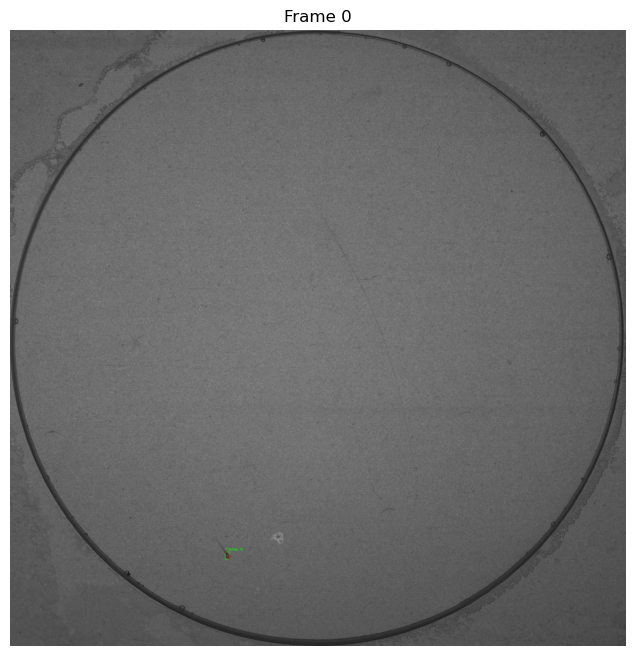

Frame visualization complete.


In [59]:
# Paths to your files
video_path = "Cam2010094.mp4"
keypoints_csv = "Cam2010094_2025_01_30_21_19_30.csv"

# Visualize specific frames (adjust these to match frames in your CSV)
frame_indices = [0]

visualize_video_frames(
    video_path=video_path,
    keypoints_csv=keypoints_csv,
    frame_indices=frame_indices,
    img_width=4512,
    img_height=4512,
    show_keypoints=True,
    save_frames=True,
    output_dir="output_frames"
)

In [53]:
class VideoZoomBrowser:
    """
    Interactive video browser with bounding box visualization and zoom capability.
    """
    
    def __init__(
        self,
        video_path: str,
        keypoints_csv: str,
        img_width: int = 3208,
        img_height: int = 2200,
        show_keypoints: bool = True
    ):
        """
        Initialize the video browser.
        
        Args:
            video_path: Path to the video file
            keypoints_csv: Path to the CSV file with keypoints
            img_width: Width of the original image for keypoint scaling
            img_height: Height of the original image for keypoint scaling
            show_keypoints: Whether to show keypoints in addition to bounding boxes
        """
        self.video_path = video_path
        self.keypoints_csv = keypoints_csv
        self.img_width = img_width
        self.img_height = img_height
        self.show_keypoints = show_keypoints
        
        # Zoom state
        self.is_zoomed = False
        self.zoom_region = None
        self.zoom_factor = 2.0  # Default zoom factor
        
        # Initialize KeypointProcessor
        self.processor = KeypointProcessor(img_width=img_width, img_height=img_height)
        
        # Load keypoints data
        self.df_keypoints = self.processor.extract_keypoints_from_csv(keypoints_csv)
        
        # Create a frame mapping for quick lookup
        self.frame_map = {row['frame_id']: row for _, row in self.df_keypoints.iterrows()}
        self.available_frames = sorted(self.frame_map.keys())
        
        # Open the video
        self.cap = cv2.VideoCapture(video_path)
        
        if not self.cap.isOpened():
            raise ValueError(f"Could not open video file {video_path}")
        
        # Get video properties
        self.video_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.video_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        print(f"Video properties:")
        print(f"  - Dimensions: {self.video_width}x{self.video_height}")
        print(f"  - FPS: {self.fps}")
        print(f"  - Total frames: {self.total_frames}")
        print(f"  - Duration: {self.total_frames/self.fps:.2f} seconds")
        print(f"  - Frames with keypoints: {len(self.available_frames)}")
        
        # Current frame index (start with the first available frame)
        self.current_frame_idx = self.available_frames[0] if self.available_frames else 0
        
        # Current frame cache
        self.current_frame = None
        self.current_frame_rgb = None
        
        # Initialize widgets
        self.setup_widgets()
    
    def setup_widgets(self):
        """Set up interactive widgets."""
        # Frame slider
        if self.available_frames:
            min_frame = min(self.available_frames)
            max_frame = max(self.available_frames)
        else:
            min_frame = 0
            max_frame = self.total_frames - 1
        
        self.frame_slider = widgets.IntSlider(
            value=self.current_frame_idx,
            min=min_frame,
            max=max_frame,
            step=1,
            description='Frame:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
        )
        
        # Navigation buttons
        self.prev_button = widgets.Button(
            description='Prev Frame',
            disabled=False,
            button_style='',
            tooltip='Go to previous frame',
            icon='chevron-left'
        )
        
        self.next_button = widgets.Button(
            description='Next Frame',
            disabled=False,
            button_style='',
            tooltip='Go to next frame',
            icon='chevron-right'
        )
        
        # Jump buttons
        self.jump_prev_button = widgets.Button(
            description='Jump -10',
            disabled=False,
            button_style='',
            tooltip='Jump back 10 frames',
            icon='fast-backward'
        )
        
        self.jump_next_button = widgets.Button(
            description='Jump +10',
            disabled=False,
            button_style='',
            tooltip='Jump forward 10 frames',
            icon='fast-forward'
        )
        
        # Specific frame input
        self.frame_input = widgets.IntText(
            value=self.current_frame_idx,
            description='Go to:',
            disabled=False
        )
        
        self.go_button = widgets.Button(
            description='Go',
            disabled=False,
            button_style='',
            tooltip='Go to specified frame',
            icon='arrow-right'
        )
        
        # Options
        self.show_keypoints_checkbox = widgets.Checkbox(
            value=self.show_keypoints,
            description='Show Keypoints',
            disabled=False
        )
        
        self.show_bbox_checkbox = widgets.Checkbox(
            value=True,
            description='Show Bounding Box',
            disabled=False
        )
        
        # Zoom controls
        self.zoom_button = widgets.Button(
            description='Toggle Zoom Mode',
            disabled=False,
            button_style='',
            tooltip='Toggle zoom selection mode',
            icon='search'
        )
        
        self.reset_zoom_button = widgets.Button(
            description='Reset Zoom',
            disabled=False,
            button_style='',
            tooltip='Reset to full view',
            icon='refresh'
        )
        
        self.zoom_factor_slider = widgets.FloatSlider(
            value=2.0,
            min=1.5,
            max=5.0,
            step=0.5,
            description='Zoom Factor:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        
        # Auto-zoom to bounding box
        self.zoom_to_bbox_button = widgets.Button(
            description='Zoom to Bounding Box',
            disabled=False,
            button_style='',
            tooltip='Automatically zoom to the bounding box',
            icon='search-plus'
        )
        
        # Save button
        self.save_button = widgets.Button(
            description='Save Frame',
            disabled=False,
            button_style='',
            tooltip='Save current frame',
            icon='save'
        )
        
        # Output area for the image
        self.output = widgets.Output()
        
        # Set up event handlers
        self.frame_slider.observe(self.on_slider_change, names='value')
        self.prev_button.on_click(self.on_prev_button_click)
        self.next_button.on_click(self.on_next_button_click)
        self.jump_prev_button.on_click(self.on_jump_prev_button_click)
        self.jump_next_button.on_click(self.on_jump_next_button_click)
        self.go_button.on_click(self.on_go_button_click)
        self.show_keypoints_checkbox.observe(self.on_option_change, names='value')
        self.show_bbox_checkbox.observe(self.on_option_change, names='value')
        self.save_button.on_click(self.on_save_button_click)
        self.zoom_button.on_click(self.on_zoom_button_click)
        self.reset_zoom_button.on_click(self.on_reset_zoom_button_click)
        self.zoom_factor_slider.observe(self.on_zoom_factor_change, names='value')
        self.zoom_to_bbox_button.on_click(self.on_zoom_to_bbox_button_click)
        
        # Arrange widgets
        self.nav_buttons = widgets.HBox([self.jump_prev_button, self.prev_button, self.next_button, self.jump_next_button])
        self.go_box = widgets.HBox([self.frame_input, self.go_button])
        self.options_box = widgets.HBox([self.show_bbox_checkbox, self.show_keypoints_checkbox])
        self.zoom_box = widgets.HBox([self.zoom_button, self.reset_zoom_button, self.zoom_to_bbox_button, self.zoom_factor_slider])
        self.save_box = widgets.HBox([self.save_button])
        
        # Main layout
        self.widget = widgets.VBox([
            self.frame_slider,
            self.nav_buttons,
            self.go_box,
            self.options_box,
            self.zoom_box,
            self.save_box,
            self.output
        ])
    
    def display(self):
        """Display the browser widget and initial frame."""
        display(self.widget)
        self.update_frame()
    
    def get_frame(self, frame_idx):
        """Get a specific frame from the video."""
        # Set video position to this frame
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        
        # Read the frame
        ret, frame = self.cap.read()
        
        if not ret:
            print(f"Warning: Could not read frame {frame_idx} from video.")
            return None
        
        return frame
    
    def draw_annotations(self, frame, frame_idx):
        """Draw bounding box and keypoints on the frame."""
        # Check if this frame has keypoint data
        if frame_idx not in self.frame_map:
            return frame
        
        # Get keypoints and bounding box data for this frame
        keypoint_data = self.frame_map[frame_idx]
        
        # Initialize bounding box coordinates
        bbox_coords = None
        
        # Draw bounding box if enabled
        if self.show_bbox_checkbox.value:
            # Get normalized bounding box coordinates
            x, y, w, h = (
                keypoint_data['bbox_x'],
                keypoint_data['bbox_y'],
                keypoint_data['bbox_width'],
                keypoint_data['bbox_height']
            )
            
            # Convert normalized coordinates to pixel coordinates
            x_pixel = int(x * self.video_width)
            y_pixel = int(y * self.video_height)
            w_pixel = int(w * self.video_width)
            h_pixel = int(h * self.video_height)
            
            # Calculate bounding box corners
            x1 = max(0, int(x_pixel - w_pixel / 2))
            y1 = max(0, int(y_pixel - h_pixel / 2))
            x2 = min(self.video_width - 1, int(x_pixel + w_pixel / 2))
            y2 = min(self.video_height - 1, int(y_pixel + h_pixel / 2))
            
            # Store bbox coordinates for auto-zoom
            bbox_coords = (x1, y1, x2, y2)
            
            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Draw label
            cv2.putText(
                frame,
                f"Frame: {frame_idx}",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
                (0, 255, 0),
                2
            )
        
        # Draw keypoints if enabled
        if self.show_keypoints_checkbox.value and 'keypoints_raw' in keypoint_data:
            keypoints = keypoint_data['keypoints_raw']
            
            # Assuming id_x_y format
            for i in range(len(keypoints) // 3):
                kpt_id = int(keypoints[i*3])
                kpt_x = int(keypoints[i*3+1] * self.video_width / self.img_width)
                kpt_y = int((self.img_height - keypoints[i*3+2]) * self.video_height / self.img_height)
                
                # Draw keypoint
                cv2.circle(frame, (kpt_x, kpt_y), 5, (0, 0, 255), -1)
                
                # Draw keypoint ID
                cv2.putText(
                    frame,
                    str(kpt_id),
                    (kpt_x + 5, kpt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (0, 0, 255),
                    1
                )
        
        return frame, bbox_coords
    
    def on_zoom_select(self, eclick, erelease):
        """Handle zoom selection."""
        self.is_zoomed = True
        
        # Get the coordinates in the right format
        x1, y1 = int(min(eclick.xdata, erelease.xdata)), int(min(eclick.ydata, erelease.ydata))
        x2, y2 = int(max(eclick.xdata, erelease.xdata)), int(max(eclick.ydata, erelease.ydata))
        
        # Ensure coordinates are within bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(self.video_width, x2)
        y2 = min(self.video_height, y2)
        
        # Store the zoom region
        self.zoom_region = (x1, y1, x2, y2)
        
        # Update the frame
        self.update_frame()
    
    def apply_zoom(self, frame_rgb):
        """Apply zoom to the frame."""
        if not self.is_zoomed or self.zoom_region is None:
            return frame_rgb
        
        x1, y1, x2, y2 = self.zoom_region
        
        # Crop the frame
        zoomed_frame = frame_rgb[y1:y2, x1:x2]
        
        return zoomed_frame
    
    def update_frame(self):
        """Update the displayed frame."""
        with self.output:
            clear_output(wait=True)
            
            # Get the frame if not already cached
            if self.current_frame is None or self.current_frame_idx != self.frame_slider.value:
                self.current_frame_idx = self.frame_slider.value
                self.current_frame = self.get_frame(self.current_frame_idx)
            
            if self.current_frame is None:
                print(f"Error: Could not read frame {self.current_frame_idx}")
                return
            
            # Make a copy to avoid modifying the original
            frame = self.current_frame.copy()
            
            # Draw annotations
            frame, bbox_coords = self.draw_annotations(frame, self.current_frame_idx)
            
            # Convert from BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            self.current_frame_rgb = frame_rgb
            
            # Apply zoom if necessary
            display_frame = frame_rgb
            if self.is_zoomed and self.zoom_region is not None:
                display_frame = self.apply_zoom(frame_rgb)
            
            # Display the frame
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.imshow(display_frame)
            
            # Add title
            title = f"Frame {self.current_frame_idx}"
            if self.current_frame_idx in self.frame_map:
                title += " (has keypoints)"
            else:
                title += " (no keypoints)"
            
            if self.is_zoomed:
                x1, y1, x2, y2 = self.zoom_region
                title += f" - Zoomed Region: ({x1},{y1}) to ({x2},{y2})"
            
            ax.set_title(title)
            ax.axis('off')
            
            # Set up the zoom selector if in zoom mode
            if hasattr(self, 'zoom_mode') and self.zoom_mode:
                self.rect_selector = RectangleSelector(
                    ax, self.on_zoom_select,
                    useblit=True,
                    button=[1],  # Left mouse button
                    minspanx=5, minspany=5,
                    spancoords='pixels',
                    interactive=True
                )
            
            plt.tight_layout()
            plt.show()
    
    def on_slider_change(self, change):
        """Handle slider value change."""
        self.current_frame_idx = change['new']
        self.frame_input.value = self.current_frame_idx
        self.current_frame = None  # Clear cache
        self.update_frame()
    
    def on_prev_button_click(self, b):
        """Handle previous button click."""
        if self.current_frame_idx > 0:
            self.current_frame_idx -= 1
            self.frame_slider.value = self.current_frame_idx
    
    def on_next_button_click(self, b):
        """Handle next button click."""
        if self.current_frame_idx < self.total_frames - 1:
            self.current_frame_idx += 1
            self.frame_slider.value = self.current_frame_idx
    
    def on_jump_prev_button_click(self, b):
        """Handle jump previous button click."""
        self.current_frame_idx = max(0, self.current_frame_idx - 10)
        self.frame_slider.value = self.current_frame_idx
    
    def on_jump_next_button_click(self, b):
        """Handle jump next button click."""
        self.current_frame_idx = min(self.total_frames - 1, self.current_frame_idx + 10)
        self.frame_slider.value = self.current_frame_idx
    
    def on_go_button_click(self, b):
        """Handle go button click."""
        frame_idx = self.frame_input.value
        if 0 <= frame_idx < self.total_frames:
            self.current_frame_idx = frame_idx
            self.frame_slider.value = self.current_frame_idx
    
    def on_option_change(self, change):
        """Handle option change."""
        self.update_frame()
    
    def on_zoom_button_click(self, b):
        """Handle zoom button click."""
        # Toggle zoom mode
        if not hasattr(self, 'zoom_mode'):
            self.zoom_mode = True
        else:
            self.zoom_mode = not self.zoom_mode
        
        # Update button text
        if self.zoom_mode:
            self.zoom_button.description = "Exit Zoom Mode"
            self.zoom_button.icon = "times"
            print("Zoom mode enabled. Click and drag on the image to select a region to zoom.")
        else:
            self.zoom_button.description = "Toggle Zoom Mode"
            self.zoom_button.icon = "search"
            print("Zoom mode disabled.")
        
        # Update the frame to enable/disable the selector
        self.update_frame()
    
    def on_reset_zoom_button_click(self, b):
        """Handle reset zoom button click."""
        self.is_zoomed = False
        self.zoom_region = None
        self.update_frame()
    
    def on_zoom_factor_change(self, change):
        """Handle zoom factor change."""
        self.zoom_factor = change['new']
        # Only update if already zoomed
        if self.is_zoomed and self.zoom_region is not None:
            self.update_frame()
    
    def on_zoom_to_bbox_button_click(self, b):
        """Handle zoom to bounding box button click."""
        # Check if current frame has keypoint data
        if self.current_frame_idx not in self.frame_map:
            print(f"Frame {self.current_frame_idx} does not have keypoint data.")
            return
        
        # Get keypoints and bounding box data for this frame
        keypoint_data = self.frame_map[self.current_frame_idx]
        
        # Get normalized bounding box coordinates
        x, y, w, h = (
            keypoint_data['bbox_x'],
            keypoint_data['bbox_y'],
            keypoint_data['bbox_width'],
            keypoint_data['bbox_height']
        )
        
        # Convert normalized coordinates to pixel coordinates
        x_pixel = int(x * self.video_width)
        y_pixel = int(y * self.video_height)
        w_pixel = int(w * self.video_width)
        h_pixel = int(h * self.video_height)
        
        # Calculate bounding box corners with padding
        padding = 20  # Pixels of padding around the bounding box
        x1 = max(0, int(x_pixel - w_pixel / 2) - padding)
        y1 = max(0, int(y_pixel - h_pixel / 2) - padding)
        x2 = min(self.video_width - 1, int(x_pixel + w_pixel / 2) + padding)
        y2 = min(self.video_height - 1, int(y_pixel + h_pixel / 2) + padding)
        
        # Set zoom region
        self.zoom_region = (x1, y1, x2, y2)
        self.is_zoomed = True
        
        # Update the frame
        self.update_frame()
    
    def on_save_button_click(self, b):
        """Handle save button click."""
        # Create output directory if it doesn't exist
        output_dir = "saved_frames"
        os.makedirs(output_dir, exist_ok=True)
        
        # Get the frame
        if self.current_frame is None:
            self.current_frame = self.get_frame(self.current_frame_idx)
        
        if self.current_frame is None:
            print(f"Error: Could not read frame {self.current_frame_idx}")
            return
        
        # Make a copy to avoid modifying the original
        frame = self.current_frame.copy()
        
        # Draw annotations
        frame, _ = self.draw_annotations(frame, self.current_frame_idx)
        
        # Save full frame
        output_path = os.path.join(output_dir, f"frame_{self.current_frame_idx:04d}.jpg")
        cv2.imwrite(output_path, frame)
        
        # If zoomed, also save zoomed region
        if self.is_zoomed and self.zoom_region is not None:
            x1, y1, x2, y2 = self.zoom_region
            zoomed_frame = frame[y1:y2, x1:x2]
            zoomed_output_path = os.path.join(output_dir, f"frame_{self.current_frame_idx:04d}_zoomed.jpg")
            cv2.imwrite(zoomed_output_path, zoomed_frame)
            print(f"Saved frame to {output_path} and zoomed region to {zoomed_output_path}")
        else:
            print(f"Saved frame to {output_path}")
    
    def close(self):
        """Release resources."""
        self.cap.release()


# Example usage
def run_video_zoom_browser(video_path, keypoints_csv):
    browser = VideoZoomBrowser(
        video_path=video_path,
        keypoints_csv=keypoints_csv,
        img_width=4512,
        img_height=4512,
        show_keypoints=True
    )
    browser.display()
    return browser

In [54]:
browser = run_video_zoom_browser("Cam2010094.mp4", "Cam2010094_2025_01_30_21_19_30.csv")

Video properties:
  - Dimensions: 4512x4512
  - FPS: 70.03891050583658
  - Total frames: 13125
  - Duration: 187.40 seconds
  - Frames with keypoints: 290


In [55]:
browser.close()